In [1]:
__author__ = 'Knut Olsen <knut.olsen@noirlab.edu>, Robert Nikutta <robert.nikutta@noirlab.edu>' # single string; emails in <>
__version__ = '20220515' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['smash_dr1','des_dr1']  # enter used datasets by hand
__keywords__ = ['tutorial','query','image cutout','globular cluster']

# Welcome to Astro Data Lab
*Knut Olsen, Robert Nikutta, Astro Data Lab Team*

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Basic info about database tables](#basic)
* [A simple database query](#query)
* [An image cutout](#image)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
Learn how to:
* Import standard Data Lab modules
* Set up the Simple Image Access (SIA) Service to let you create image cutouts
* Discover the datasets available in the database
* Issue a simple query to the database
* Retrieve image cutouts
* Create a color image


<a class="anchor" id="summary"></a>
# Summary

If you've gotten this far, you're planning to use the Data Lab Jupyter notebook environment to access, explore, and analyze datasets available in the Data Lab.  This notebook aims to provide you with a very quick overview of how to use some common Data Lab services.  For more detailed explanations of data access, the full range of services, or for complete science examples, check out the other notebooks in this directory tree.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup
To use the Data Lab, you'll generally want to import common packages such as NumPy and matplotlib.  From the datalab package, you'll at minimum need the authClient module to get an authorization token (even if using Data Lab anonymously) and the queryClient module to issue a query against the catalog database.

For storing results in virtual storage and myDB, you'll need the storeClient module *and* log in as an authenticated user.  

The helpers module has many convience functions.  See the <a href="http://datalab.noirlab.edu/docs/manual/UsingAstroDataLab/ClientInterfaces/Helpers/Helpers.html">online documentation</a> for a summary.

Use of the image cutout service (SIA) requires the external PyVO package, and the URL of the SIA service that you will use.  Data Lab has a general SIA service containing all available images from Astro Data Archive, as well as a number of survey-specific services.  See the SIA service HowTo for examples.

In [2]:
# std library imports
from getpass import getpass

# 3rd party
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io
from astropy.visualization import make_lupton_rgb
%matplotlib inline

# Data Lab and related imports

# You'll need at least these for authenticating and for issuing database queries
from dl import authClient as ac, queryClient as qc

# Get helpers for various convenience function
from dl.helpers.utils import convert

# You'll want storeClient if you plan to use virtual storage or myDB
# from dl import storeClient as sc

# To get image cutouts, you'll need the VO-based SIA package, and define which SIA service to use
from pyvo.dal import sia
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr1" # DES SIA service URL
svc = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="auth"></a>
# Authentication
For the purposes of this notebook, there is no need to log in with your username and password inside the notebook. As an anonymous user, you can issue queries to the database or retrieve image cutouts, but not store your results in virtual storage or myDB.  If you need these things, you would use the *authClient* module to log in.  You only need to do this once (unless you log out through authClient), as the authentication token is stored on the server and automatically detected. 

In [3]:
# As an anonymous user, you can issue queries to the database or retrieve image cutouts, but
# not store your results in virtual storage or myDB

# Get token for an authenticated user if you wish to use virtual storage or myDB
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))
ac.whoAmI()

'robertdemo'

<a class="anchor" id="basic"></a>
# Basic info about database tables

### What datasets are available?
The queryClient has a <tt>schema</tt> method to give you information about available databases, tables, and columns.  If we call <tt>qc.schema()</tt> with an empty first argument, we'll get information on the available datasets and a one-line description for most of them.

In [4]:
print(qc.schema())


     Schema Name   Description
     -----------   -----------
         allwise   The AllWISE data release
     catwise2020   CatWise 2020 data, containing the main catalog with 190 co
                   lumns and 5 cross-match tables with main catalogs: AllWise
                   DR2, GAIA EDR3, NSC DR2, SDSS DR16 and unWise DR1
         dad_dr1   DECam Asteroid Database -- Data Release 1
         dad_dr2   DECam Asteroid Database -- Data Release 2
      decaps_dr1   DECaPS Survey Data Release 1
       delve_dr1   First data release of the DELVE survey (Drlica-Wagner et a
                   l. 2020)
       delve_dr2   Second data release of the DELVE survey
         des_dr1   Dark Energy Survey (DES) Data Release 1
         des_dr2   Dark Energy Survey (DES) Data Release 2
        des_sva1   DES SVA1 Data Products
          dltest   
        gaia_dr1   GAIA Data Release 1
        gaia_dr2   Gaia Data Release 2 -- April 25, 2018
       gaia_edr3   The early installment of the third Gai

### Get list of tables
If we call qc.schema() with a specific dataset name, we'll see what tables are available for that dataset.  Here's what's available for SMASH DR1:

In [5]:
print(qc.schema('smash_dr1'))


Schema: smash_dr1

      Table Name   Description
      ----------   -----------
            chip   Info on each chip in the frame
        exposure   Info on each exposure
           field   Info on each target field (position, Num exposures, etc)
        galaxies   View of object table to select for galaxies
          object   Average photometry of each unique object
          source   All of the individual source measurements
           stars   View of object table to select for stars
x1p5__object__gaia_dr2__gaia_source   smash_dr1.object and gaia_dr2.gaia_source crossmatch (1.5 
                   arcsec)
x1p5__object__nsc_dr2__object   smash_dr1.object and nsc_dr2.object crossmatch (1.5 arcsec)
x1p5__object__unwise_dr1__object   smash_dr1.object and unwise_dr1.object crossmatch (1.5 arcsec)
          xmatch   Crossmatch of object against GAIA DR1 and WISE



### Get list of columns
We can also use qc.schema() to get column names and descriptions for a specific table.  Here's what's available for the SMASH DR1 object table.  (Note that not all datasets have column descriptions for every column).

In [6]:
print(qc.schema('smash_dr1.object'))


Schema: smash_dr1
 Table: object

     Column Name   Description
     -----------   -----------
              id   Unique ID for this object, the field name plus a running number
         fieldid   SMASH Field ID
              ra   Right Ascension (J2000.0) of source, in degrees
             dec   Declination (J2000.0) of source, in degrees
            glon   Galactic Longitude
            glat   Galactic Latitude
            elon   Ecliptic Longitude
            elat   Ecliptic Latitude
            htm9   HTM index (order 9 => ~10 arcmin size)
         ring256   HEALPIX index (Nsides 256, Ring scheme => ~14 arcmin size)
        nest4096   HEALPIX index (Nsides 4096, Nest scheme => ~52 arcsec size
       random_id   Random ID in the range 0.0 => 100.0
           raerr   Uncertainty in mean RA of object (arcseconds) from indiv values
          decerr   Uncertainty in mean DEC of object (arcseconds) from indiv 
                   values
            ndet   Number of detections of this so

### Getting statistics for tables
You'll often want to get some basic information about a given table, e.g. the number of rows.  One might be tempted to use `SELECT COUNT(*)` in a query for this -- but that can be slow on large datasets, and is often not needed. Instead, the special database `tbl_stat` contains this information for each dataset. Let's query this table instead:

In [7]:
#query = "SELECT COUNT(ra) FROM phat_v2.phot_mod" # SLOW
query = "SELECT * FROM tbl_stat WHERE schema='smash_dr1' AND tbl_name='object'" # Retrieve useful stats, quickly

In [8]:
%%time
info = qc.query(sql=query) # by default the result is a CSV formatted string

CPU times: user 23.6 ms, sys: 5.11 ms, total: 28.7 ms
Wall time: 155 ms


In [9]:
print(info)

schema,tbl_name,nrows,ncols,nindex,table_size,indexes_size,total_size
smash_dr1,object,101425208,45,27,22 GB,39 GB,61 GB



<a class="anchor" id="query"></a>
# A simple query for catalog data
In the above section we already saw a basic query of the `tbl_stats` database. Here we will retrieve the first 10 rows from the `smash_dr1.object` table:

In [10]:
%%time
query = "SELECT * FROM smash_dr1.object LIMIT 10"
result = qc.query(sql=query) # by default the result is a CSV formatted string

CPU times: user 25.2 ms, sys: 2.35 ms, total: 27.6 ms
Wall time: 110 ms


Note that by default the result is returned as a long string that looks like a CSV file:

In [11]:
print(type(result))
print(result[:1000]) # print just the first 1000 characters of the returned string

<class 'str'>
ra,dec,glon,glat,elon,elat,htm9,ring256,nest4096,random_id,raerr,decerr,umag,uerr,uscatter,gmag,gerr,gscatter,rmag,rerr,rscatter,imag,ierr,iscatter,zmag,zerr,zscatter,u_g,g_r,g_i,i_z,chi,sharp,prob,ebv,ndet,depthflag,ndetu,ndetg,ndetr,ndeti,ndetz,flag,fieldid,id
103.61664648393815,-37.82251079630776,247.80812412349988,-15.683732561201733,111.99318166805573,-60.22638825521978,2590804,634662,162335445,92.58048,0.044626486,0.044626486,99.99,9.99,99.99,25.106007,0.37917355,99.99,24.49019,0.12796059,0.090071455,24.334368,0.13720524,0.16739261,23.799118,0.2228987,0.12288359,0,0.6158161,0.7716389,0.5352497,0.8977778,0.43333334,0.25,0.13434735,9,2,0,1,3,3,2,0,153,153.410153 
103.61616318072434,-37.82248573604162,247.8079487449665,-15.684075875916045,111.99241714108135,-60.22643563917857,2590804,634662,162335445,34.26457,0.33653313,0.33653313,23.0946,0.44564682,99.99,99.99,9.99,99.99,99.99,9.99,99.99,99.99,9.99,99.99,99.99,9.99,99.99,0,0,0,0,1.244,-4.749,99.99,0.13438752,1,1,1,0,0

We would generally want to convert this string into a table or an array, i.e., into some format that allows numerical processing.  The Data Lab `helpers` module makes it easy. Here we convert the result string result into a Pandas dataframe:

In [12]:
df = convert(result,'pandas')
df.head()

,ra,dec,glon,glat,elon,elat,htm9,ring256,nest4096,random_id,...,ndet,depthflag,ndetu,ndetg,ndetr,ndeti,ndetz,flag,fieldid,id
0,103.616646,-37.822511,247.808124,-15.683733,111.993182,-60.226388,2590804,634662,162335445,92.580480,...,9,2,0,1,3,3,2,0,153,153.410153
1,103.616163,-37.822486,247.807949,-15.684076,111.992417,-60.226436,2590804,634662,162335445,34.264570,...,1,1,1,0,0,0,0,-1,153,153.154644
2,103.614209,-37.821254,247.806154,-15.685032,111.988897,-60.225517,2590804,634662,162335445,37.099964,...,1,1,0,1,0,0,0,-1,153,153.802516
3,103.615689,-37.820984,247.806359,-15.683849,111.991107,-60.225032,2590804,634662,162335445,39.546013,...,1,1,1,0,0,0,0,-1,153,153.154639
4,103.617927,-37.821062,247.807134,-15.682245,111.994632,-60.224775,2590920,633639,162335616,31.651989,...,1,1,1,0,0,0,0,-1,153,153.154640


Note that for convenience one can request the result to be in a number of other formats, including a Pandas DataFrame: 

In [13]:
%%time
query = "SELECT * FROM smash_dr1.object LIMIT 10"
df = qc.query(sql=query,fmt='pandas')
df.head()

CPU times: user 33.6 ms, sys: 1.38 ms, total: 35 ms
Wall time: 134 ms


,ra,dec,glon,glat,elon,elat,htm9,ring256,nest4096,random_id,...,ndet,depthflag,ndetu,ndetg,ndetr,ndeti,ndetz,flag,fieldid,id
0,103.616646,-37.822511,247.808124,-15.683733,111.993182,-60.226388,2590804,634662,162335445,92.580480,...,9,2,0,1,3,3,2,0,153,153.410153
1,103.616163,-37.822486,247.807949,-15.684076,111.992417,-60.226436,2590804,634662,162335445,34.264570,...,1,1,1,0,0,0,0,-1,153,153.154644
2,103.614209,-37.821254,247.806154,-15.685032,111.988897,-60.225517,2590804,634662,162335445,37.099964,...,1,1,0,1,0,0,0,-1,153,153.802516
3,103.615689,-37.820984,247.806359,-15.683849,111.991107,-60.225032,2590804,634662,162335445,39.546013,...,1,1,1,0,0,0,0,-1,153,153.154639
4,103.617927,-37.821062,247.807134,-15.682245,111.994632,-60.224775,2590920,633639,162335616,31.651989,...,1,1,1,0,0,0,0,-1,153,153.154640


The results of a query like this can be stored to your VOSpace (remote user file storage) or to MyDB (remote user database), if you logged in as an authenticated user. See some of the Data Lab [How-To notebooks](https://github.com/astro-datalab/notebooks-latest/tree/058d6a71dbdd7f4f19a38f5ec6f78cd9b107113c/04_HowTos) for for examples of this.

<a class="anchor" id="image"></a>
# Find and download an image cutout
Using the image cutout service is a two-step process. First, we specify a position (RA and Dec), and the size of the image that we want to retrieve. Second, we then search the SIA service for all images that overlap that point on the sky:

In [14]:
# NGC 288 (a globular cluster)
ra = 13.19     # in decimal degrees
dec = -26.59   # in decimal degrees

fov = 13/60  # image cutout field of view (in degrees; here 13 arminutes = 0.22 degrees)

imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()  # uses declination correction

The result is a VOTable that we convert to an astropy Table on the fly. The table contains many columns of metadata describing the parameters of each image, including a URL for the cutout itself. Note, however, that data quality images such as masks or weight maps can also appear in the list:

In [15]:
print(type(imgTable))
imgTable

<class 'astropy.table.table.Table'>


assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_det.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667",image/fits,87384,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0052-2623_r2628p04_det.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_det.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667&preview=true",,,13.0308,-26.3966,--,,,--,-2.98156e-39,2.98156e-39,--,--,--,--,--,--,,,,DES0052-2623,0,DES DR1,30,image,0,0,,1350,,Stack,,556997.0815869,0
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_det.fits.fz&extn=2&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667",image/fits,87384,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0052-2623_r2628p04_det.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_det.fits.fz&extn=2&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667&preview=true",,,13.0308,-26.3966,--,,,--,-3.05931e-41,3.05931e-41,--,--,--,--,--,--,,,,DES0052-2623,0,DES DR1,30,mask,0,0,,1350,,Stack,,556997.0815869,0
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_det.fits.fz&extn=3&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667",image/fits,87384,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,,,,ivo://datalab.noirlab/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0052-2623_r2628p04_det.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_det.fits.fz&extn=3&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667&preview=true",,,13.0308,-26.3966,--,,,--,-8.96831e-44,8.96831e-44,--,--,--,--,--,--,,,,DES0052-2623,0,DES DR1,30,weight,0,0,,1350,,Stack,,556997.0815869,0
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_g.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667",image/fits,165791,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0052-2623_r2628p04_g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_g.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667&preview=true",,,13.0308,-26.3966,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES0052-2623,0,DES DR1,30,image,0,0,,540,,Stack,,557004.06109019,0
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_g.fits.fz&e

The next step is to identify the image that you want from the list of available images.  Here we will limit the list to g-band image stacks, and select the `image` product type (rather than weights or masks).

In [16]:
# boolean selection for just g-band images
sel0 = imgTable['obs_bandpass'] == 'g'

# logically add selections for 'Stack' and 'image' product type
sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection

# filter the above results table
Table = imgTable[sel] # select
Table

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr1,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_g.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667",image/fits,165791,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0052-2623_r2628p04_g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_g.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667&preview=true",,,13.0308,-26.3966,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES0052-2623,0,DES DR1,30,image,0,0,,540,,Stack,,557004.06109019,0


The final step is to extract the URL and download the image:

In [17]:
row = Table[0]
url = row['access_url'] # get the download URL
print(url)

https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_g.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667


In [18]:
gimage = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

We'll do a quick display here:

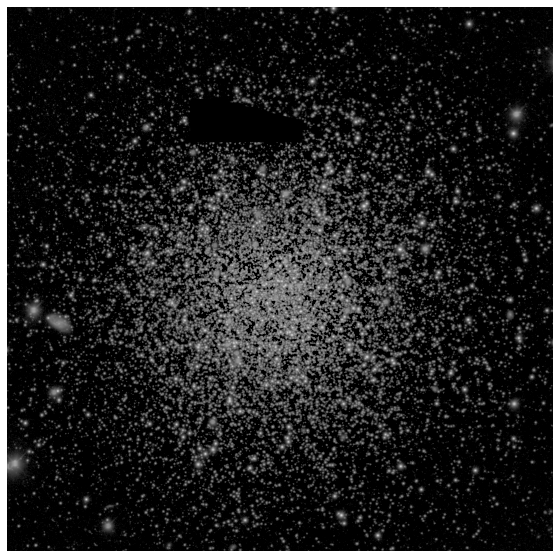

In [19]:
fig = plt.subplots(figsize=(10,10))
plt.imshow(np.arcsinh(gimage),cmap='gray',norm=matplotlib.colors.Normalize(vmin=0))
plt.axis('off');

## Let's make a color image
Let's write a quick function to do the SIA query and image selection for us:

In [20]:
# A function to download the deepest available stacked images
def download_deep_stack(ra,dec,fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    print("The full image list contains", len(imgTable), "entries")

    # apply image seletion criteria
    sel0 = imgTable['obs_bandpass'] == band
    sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection
    Table = imgTable[sel] # select

    # if more than one image matches our desired criteria
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print ('Downloading deepest stacked image...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))
        print(url)

    # if no images match our criteria
    else:
        print ('No image available.')
        image = None
        
    print()
    return image

Using this function we can now quickly download two more bands (r and i bands), and combine them with the g-band image to make a false-color image:

In [21]:
rimage = download_deep_stack(ra,dec,fov,band='r')
iimage = download_deep_stack(ra,dec,fov,band='i')

The full image list contains 18 entries
https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_r.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667

The full image list contains 18 entries
https://datalab.noirlab.edu/svc/cutout?col=des_dr1&siaRef=DES0052-2623_r2628p04_i.fits.fz&extn=1&POS=13.19,-26.59&SIZE=0.2422934725574616,0.21666666666666667



Now we can do the combination of images in three bands:

In [22]:
color_image = make_lupton_rgb(iimage, rimage, gimage, stretch=100, Q=0.1)

And plot the resulting false-color image:

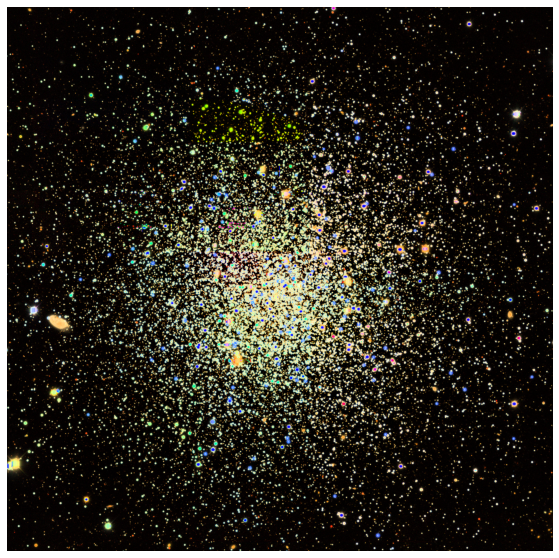

In [23]:
fig = plt.figure(figsize=(10,10))
plt.imshow(color_image)
plt.axis('off');

<a class="anchor" id="resources"></a>
# Further resources and references
* This notebook is [available on GitHub](https://github.com/astro-datalab/notebooks-latest/blob/058d6a71dbdd7f4f19a38f5ec6f78cd9b107113c/01_GettingStartedWithDataLab/02_GettingStartedWithDataLab.ipynb)
* An in-depth [notebook on Simple Image Access](https://github.com/astro-datalab/notebooks-latest/blob/058d6a71dbdd7f4f19a38f5ec6f78cd9b107113c/04_HowTos/SiaService/How_to_use_the_Simple_Image_Access_service.ipynb)
* Info about the [globular cluster NGC 288](https://en.wikipedia.org/wiki/NGC_288)